In [4]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.Qiskit_CP_VQA import CP_VQA
from src.Qiskit_QAOA import Qiskit_QAOA

from src.Chain import Chain
from src.Qubo import Qubo
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       check_qubo)

In [ ]:
N_min, N_max = 4,8

qiskit_qaoa_res = {N: [] for N in range(N_min, N_max + 1)}
qiskit_reduced_res = {N: [] for N in range(N_min, N_max + 1)}


max_iter = 1000
N_seeds = 30
start_seed = 0
w_nnn = True

layer_dict = {4:  1, 5:  1, 6 : 1,
              7:  2, 8 : 2, 9 : 2, 
              10: 3, 11: 3, 12: 3, 
              13: 4, 14: 4, 15: 4, 
              16: 5, 17: 5, 18: 5, 
              19: 6, 20: 6, 21: 6}
 # Choosing optimizer for scipy
optimizer_method = 'COBYLA'
for N in tqdm(range(N_min, N_max+1)):
    k = N // 2
    init_strat = np.array([1 if i%2 == 1 else 0 for i in range(N)])
    my_indices = [(i, i+1) for i in range(N-1)]
    alpha = 0.5
    for repetition in range(N_seeds):
         # Defining topology
        my_chain = Chain(N_qubits=N)
        my_chain.set_initialization_strategy(strategy=init_strat)
        # Deciding between grid and 1d chain topology
        my_topology = my_chain
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=N, seed=start_seed)
        # Retrieving C_min, C_max and corresponding states for original portfolio problem
        constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                    k=k,
                                                                    mu=expected_returns,
                                                                    sigma=covariances,
                                                                    alpha=alpha)
        portfolio_subspace_max_cost, portfolio_subspace_min_cost = constrained_result['c_max'], constrained_result['c_min']
        portfolio_subspace_min_state, portfolio_subspace_max_state = constrained_result['s_min'], constrained_result['s_max']
        portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state.astype(int)])
        portfolio_subspace_max_state_str = ''.join([str(_) for _ in portfolio_subspace_max_state.astype(int)])

        # Generating QUBO corresponding to current problem instance
        Q, offset = get_qubo(mu=expected_returns,
                             sigma=covariances, 
                             alpha=alpha,
                             lmbda=lmbda+1, # Adding small constant purposely
                             k=k)
        qubo = Qubo(Q=Q, offset=offset) 
        res_subspace = qubo.solve_constrained(cardinality=k)
        res_full = qubo.solve()
        qubo_min_cost, qubo_max_cost = res_full['v_min'], res_full['v_max']
        qubo_min_state, qubo_subspace_max_state = res_full['x_min'], res_subspace['x_max']
        qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state.astype(int)])
        qubo_subspace_max_state_str = ''.join([str(_) for _ in qubo_subspace_max_state.astype(int)])
        check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
         
        skip = False
        if not portfolio_subspace_max_state_str == qubo_subspace_max_state_str:
            """ raise RuntimeError(f'portfolio_subspace_max_state_str: {portfolio_subspace_max_state_str}, qubo_max_state_str: {qubo_subspace_max_state_str}'+f' Max. cost of qubo is: {res_subspace["v_max"]}, but max. cost of constrained portfolio is: {portfolio_subspace_max_cost}.')"""
            skip = True
        
        if not portfolio_subspace_min_state_str == qubo_min_state_str:
            """raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str: {qubo_min_state_str}'+f' Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')"""
            skip = True
             
        if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
            """raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')"""
            skip = True
             
        if not qubo_max_cost >= portfolio_subspace_max_cost:
            """raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')"""
            skip = True
        if not skip:
            
            qiskit_ansatz_qaoa = Qiskit_QAOA(N_qubits=N,
                                             cardinality=k,
                                             layers=layer_dict[N],
                                             qubo=qubo)
             
            qiskit_ansatz_reduced = CP_VQA(N_qubits=N,
                                            cardinality=k,
                                            layers=layer_dict[N],
                                            topology=my_topology,
                                            with_next_nearest_neighbors=w_nnn,
                                            approximate_hamiltonian=True,
                                            qubo=qubo)
             
            
             # Generating initial guess for rotation angles
            np.random.seed(start_seed)
            theta_min, theta_max = -2*np.pi, 2*np.pi
            N_angles = layer_dict[N] * len(my_topology.get_NNN_indices()) if w_nnn else layer_dict[N] * len(my_topology.get_NN_indices())
            CPVQA_theta_i = np.random.uniform(-2*np.pi, 2*np.pi, N_angles)
            QAOA_theta_i = np.random.uniform(-2*np.pi, 2*np.pi, 2*layer_dict[N])
            
            qiskit_sim_reduced = sc.optimize.minimize(fun=qiskit_ansatz_reduced.get_cost, 
                                                      x0=CPVQA_theta_i,
                                                      method=optimizer_method,
                                                      options={'disp': False, 
                                                                'maxiter': max_iter},
                                                      callback=qiskit_ansatz_reduced.callback)
            reduced_norm_c = np.min(qiskit_ansatz_reduced.normalized_costs)
            reduced_norm_p = np.max(qiskit_ansatz_reduced.opt_state_probabilities)
            qiskit_reduced_res[N].append([reduced_norm_c,reduced_norm_p])     
            
            qaoa_sim_reduced = sc.optimize.minimize(fun=qiskit_ansatz_qaoa.get_cost, 
                                                      x0=QAOA_theta_i,
                                                      method=optimizer_method,
                                                      options={'disp': False, 
                                                                'maxiter': max_iter},
                                                      callback=qiskit_ansatz_qaoa.callback)
            qaoa_norm_c = np.min(qiskit_ansatz_qaoa.normalized_costs)
            qaoa_norm_p = np.max(qiskit_ansatz_qaoa.opt_state_probabilities)
            qiskit_qaoa_res[N].append([qaoa_norm_c,qaoa_norm_p])   
            
        start_seed += 1

 80%|████████  | 4/5 [02:58<01:04, 64.10s/it]

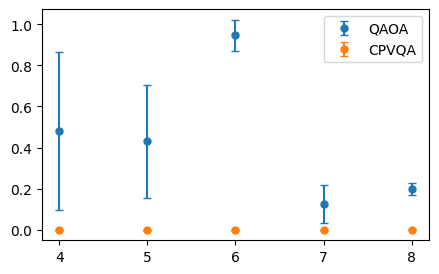

In [3]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
N_vales = [N for N in range(N_min,N_max+1)]
ax.errorbar(N_vales, [np.mean(np.array(qiskit_qaoa_res[N])[:,0]) for N in N_vales], [np.std(np.array(qiskit_qaoa_res[N])[:,0]) for N in N_vales], label='QAOA', capsize=3, fmt='.', ms=10)
ax.errorbar(N_vales, [np.mean(np.array(qiskit_reduced_res[N])[:,0]) for N in N_vales], [np.std(np.array(qiskit_reduced_res[N])[:,0]) for N in N_vales], label='CPVQA', capsize=3, fmt='.', ms=10)
ax.set_xticks(N_vales)
ax.legend()
#ax.set_ylim(0,0.2)
plt.show()